# Huggingface datasets



In [3]:
# Most basic stuff for EDA.

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# !pip install transformers
# !pip install datasets
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 

import warnings
warnings.filterwarnings("ignore")

# Read the data


In [6]:
train_tweets = pd.read_csv('../data/train.csv')
test_tweets = pd.read_csv('../data/test.csv')

In [7]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# EDA

<AxesSubplot:xlabel='count', ylabel='target'>

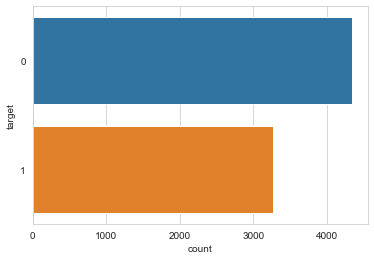

In [8]:
sns.set_style('whitegrid')
sns.countplot(y=train_tweets['target'])

In [9]:
train_tweets['location'].value_counts().head(n=20)


USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

Let's clean the text

In [12]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
import re
import string

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions on Train Dataset

train_tweets['text_clean'] = train_tweets['text'].apply(lambda x: remove_URL(x))
train_tweets['text_clean'] = train_tweets['text_clean'].apply(lambda x: remove_emoji(x))
train_tweets['text_clean'] = train_tweets['text_clean'].apply(lambda x: remove_html(x))
train_tweets['text_clean'] = train_tweets['text_clean'].apply(lambda x: remove_punct(x))

# Applying helper functions on Test Dataset

test_tweets['text_clean'] = test_tweets['text'].apply(lambda x: remove_URL(x))
test_tweets['text_clean'] = test_tweets['text_clean'].apply(lambda x: remove_emoji(x))
test_tweets['text_clean'] = test_tweets['text_clean'].apply(lambda x: remove_html(x))
test_tweets['text_clean'] = test_tweets['text_clean'].apply(lambda x: remove_punct(x))

In [32]:
train_tweets.fillna("",inplace=True)
test_tweets.fillna("",inplace=True)

In [34]:
model_nm = 'microsoft/deberta-v3-small'

In [35]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
sep = tokz.sep_token

In [37]:
train_tweets['train'] = train_tweets['text_clean'] + sep + train_tweets['location'] + sep + train_tweets['keyword']

In [38]:
train_tweets.head()

,id,keyword,location,text,target,text_clean,train
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,Our Deeds are the Reason of this earthquake Ma...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada[SEP][SEP]
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,All residents asked to shelter in place are be...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,Just got sent this photo from Ruby Alaska as s...


# Training

Time to import some stuff we'll need for training

In [41]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

from datasets import load_dataset, Dataset, DatasetDict


In [39]:
def tok_func(x):
    return tokz(x['train'])

In [42]:
ds = Dataset.from_pandas(train_tweets)

In [43]:
train_tweets.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_clean', 'train'], dtype='object')

In [44]:
tok_ds = ds.map(tok_func, batched=True, remove_columns=['id', 'keyword', 'location', 'text', 'target', 'text_clean'])

  0%|          | 0/8 [00:00<?, ?ba/s]

In [45]:
tok_ds[0]

{'train': 'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all[SEP][SEP]',
 'input_ids': [1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  10612,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2,
  2,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [48]:
dds = tok_ds.train_test_split(test_size=0.2)

# Initial model

In [49]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [50]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

AttributeError: module 'torch.distributed' has no attribute 'is_initialized'

We can now create our model, and `Trainer` which is a class which combines the data and mdoel together (just like Learner in fastai)

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=corr)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

NameError: name 'args' is not defined